In [1]:
import warnings
import pandas as pd

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

/users/4/rozan012/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import os
import time
import random
import itertools
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader


import phik
from phik.report import plot_correlation_matrix
from phik import report
# import eli5
# from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

from tqdm.notebook import tqdm

from src.PM_eq import penman_monteith
from src.process_fluxes import create_rolling_windows

# Data Preprocessing

In [3]:
df = pd.read_csv('../data_v02/dataset.csv')
df

,temperature_2m,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,surface_net_solar_radiation_sum,total_evaporation_sum,surface_pressure,total_precipitation_sum,SensorZenith,SensorAzimuth,...,LE_PM_rol_30,LE_PM_rol_7,LE_PM_min,LE_PM_max,LE_PM_std,doy,lat,lon,IGBP,LE
0,281.343946,274.774182,-2.073795,-1.360031,26897492.0,-0.002752,99228.292806,8.702277e-07,-7688.0,1044.0,...,1300.433333,-15.142857,-8091.0,14466.0,8934.811384,144,46.7305,-91.2329,DBF,19.2224
1,282.464883,275.920165,-0.567736,-0.957006,25328886.0,-0.002556,99148.981283,4.280953e-06,-6919.0,5713.0,...,1307.633333,3.428571,-8091.0,14466.0,8927.863731,145,46.7305,-91.2329,DBF,24.2024
2,284.084068,277.467796,-0.467478,-0.748162,27070394.0,-0.002731,99351.942220,-3.470632e-09,10194.0,989.0,...,1317.700000,31.142857,-8091.0,14466.0,8938.041316,146,46.7305,-91.2329,DBF,19.4017
3,285.546112,280.368587,-0.012711,0.381809,26986822.0,-0.002901,99198.711751,1.704693e-06,-7178.0,4828.0,...,1322.533333,48.571429,-8091.0,14466.0,8933.245569,147,46.7305,-91.2329,DBF,23.7468
4,287.724267,283.038661,2.504967,-0.589438,22430258.0,-0.002726,98359.807129,2.112186e-03,9959.0,2853.0,...,1333.066667,74.142857,-8091.0,14466.0,8943.574997,148,46.7305,-91.2329,DBF,42.2603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100026,297.318900,287.853605,-0.168409,4.767782,14505586.0,-0.001776,97233.082194,9.688994e-05,-7574.0,2845.0,...,-362.966667,-1297.428571,-16360.0,10298.0,9260.157236,254,46.6347,-91.0987,DBF,55.7628
100027,291.268883,287.133067,1.514562,2.380533,10545720.0,-0.001241,96738.132161,6.713572e-06,-7990.0,1027.0,...,-420.000000,-87.285714,-16360.0,10298.0,9266.910797,256,46.6347,-91.0987,DBF,31.6040
100028,289.352179,282.922236,2.427099,-0.343477,9703412.0,-0.001254,97260.959310,1.046062e-05,-6951.0,5714.0,...,-413.800000,-70.142857,-16360.0,10298.0,9262.322928,257,46.6347,-91.0987,DBF,54.2463
100029,287.695470,281.925993,3.045816,-0.182213,12917008.0,-0.001712,97294.923014,1.151973e-03,10348.0,1008.0,...,-400.900000,-13.285714,-16360.0,10348.0,9277.527589,258,46.6347,-91.0987,DBF,44.2428


In [4]:
class Dataset():
    def __init__(self, X, Y, x_scaler=None, y_scaler=None, fit_scaler=False):
        if fit_scaler:
            self.x_scaler = MinMaxScaler()  
            self.y_scaler = MinMaxScaler()  
            X = self.x_scaler.fit_transform(X) 
            Y = self.y_scaler.fit_transform(Y.reshape(-1, 1)) 
        elif x_scaler is not None:
            X = x_scaler.transform(X)  
            Y = y_scaler.transform(Y.reshape(-1, 1)) 
            
        self.x = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(Y, dtype=torch.float32).to(device)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['LE'], axis=1), df['LE'], stratify=df['IGBP'],
                                                    test_size=0.3, shuffle=True, random_state=31)

In [6]:
BATCH_SIZE = 512
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
one_hot = pd.get_dummies(X_train.IGBP)
X_train_ann = pd.concat([X_train.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)
one_hot = pd.get_dummies(X_test.IGBP)
X_test_ann = pd.concat([X_test.drop('IGBP', axis=1), one_hot.astype(int)], axis=1)

In [8]:
train_dataset = Dataset(X_train_ann, y_train.values, fit_scaler=True)
x_scaler = train_dataset.x_scaler 
y_scaler = train_dataset.y_scaler 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=False)
test_loader = DataLoader(Dataset(X_test_ann.values, y_test.values,
                                 x_scaler=x_scaler, y_scaler=y_scaler), batch_size=BATCH_SIZE, drop_last=False)

# ANN

### LOGS:
**Stratified by IGBP:**

R2: 0.982	RMSE: 5.351	MAE: 1.437

In [11]:
class ANN(nn.Module):
    def __init__(self, INPUT_SIZE, n1, n2, dropout=0.3):
        super().__init__()
	
        self.net = nn.Sequential()
        self.net.add_module('Linear_1', nn.Linear(INPUT_SIZE, n1))
        self.net.add_module('ReLU_1', nn.LeakyReLU()) #Sigmoid
        self.net.add_module('Drop_1', nn.Dropout(dropout))
        
        self.net.add_module('Linear_2', torch.nn.Linear(n1, n2))
        self.net.add_module('Norm', nn.BatchNorm1d(n2))
        self.net.add_module('ReLU_2', nn.LeakyReLU())
        self.net.add_module('Drop_2', nn.Dropout(dropout))
        self.net.add_module('Linear_3',torch.nn.Linear(n2, 1))

    def forward(self, y):
        return self.net(y)

In [19]:
num_epoch = 2000
feature_num = X_test_ann.values.shape[1]
n1 = 400
n2 = 100
dropout=0.3

In [13]:
model = ANN(feature_num, n1,n2, dropout).to(device).to(torch.float32)

In [16]:
model.load_state_dict(torch.load('../models/ANN.pth'))

<ipython-input-16-0fe9860f9e94>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/ANN.pth'))


<All keys matched successfully>

In [14]:
criteria = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [23]:
best = -np.inf
t0 = time.time()
for epoch in tqdm(range(num_epoch)):
    model.train()
    for x, y in train_loader:
        x, y = x.to(torch.float32), y.to(torch.float32)
        pred = model(x)
        error = criteria(pred, y)

        optimizer.zero_grad()
        error.backward()
        optimizer.step()

    if epoch % 5 == 0:
        model.eval()
        test_preds = []
        test_true = []
        test_x = []
        test_idx = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(torch.float32), y.to(torch.float32)
                preds = model(x)
                preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
                y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
                test_preds.append(torch.tensor(preds))
                test_true.append(torch.tensor(y_scaled))

        test_preds = torch.cat(test_preds).squeeze()
        test_true = torch.cat(test_true).squeeze()
        
        test_loss = criteria(test_preds, test_true).item()
        r2 = r2_score(test_true.numpy(), test_preds.numpy())
        mae = mean_absolute_error(test_true.numpy(), test_preds.numpy())
        #writer.add_scalar("Loss/test", test_loss, epoch)
        #writer.add_scalar("R2/test", r2, epoch)
        
        best_old = best
        best = min(test_loss, best)
        if abs(best) > best_old:
            torch.save(model.state_dict(), f'../models/ANN.pth') #0.6532
            #writer.add_text("Checkpoint", "Saved model at epoch {}".format(epoch))
        print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t Test MAE: {mae:0.4f}')
#writer.close()

Test RMSE: 10.313		Test R2: 0.9347		 Test MAE: 6.9571
Test RMSE: 10.282		Test R2: 0.9351		 Test MAE: 6.9302
Test RMSE: 10.400		Test R2: 0.9336		 Test MAE: 6.9591
Test RMSE: 10.448		Test R2: 0.9330		 Test MAE: 7.1019
Test RMSE: 10.239		Test R2: 0.9356		 Test MAE: 6.9262
Test RMSE: 10.352		Test R2: 0.9342		 Test MAE: 6.9239
Test RMSE: 10.507		Test R2: 0.9322		 Test MAE: 7.0345
Test RMSE: 10.467		Test R2: 0.9327		 Test MAE: 6.9857
Test RMSE: 10.483		Test R2: 0.9325		 Test MAE: 6.9854
Test RMSE: 10.198		Test R2: 0.9361		 Test MAE: 6.8838
Test RMSE: 10.459		Test R2: 0.9328		 Test MAE: 7.0307
Test RMSE: 10.516		Test R2: 0.9321		 Test MAE: 7.0994
Test RMSE: 10.447		Test R2: 0.9330		 Test MAE: 6.9793
Test RMSE: 10.273		Test R2: 0.9352		 Test MAE: 6.9411
Test RMSE: 10.292		Test R2: 0.9349		 Test MAE: 6.9299
Test RMSE: 10.653		Test R2: 0.9303		 Test MAE: 7.1911
Test RMSE: 10.349		Test R2: 0.9342		 Test MAE: 6.9583
Test RMSE: 10.312		Test R2: 0.9347		 Test MAE: 6.9344
Test RMSE: 10.400		Test R2: 

In [24]:
model.load_state_dict(torch.load('../models/ANN.pth'))
model.eval()
test_preds = []
test_true = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(torch.float32), y.to(torch.float32)
        preds = model(x)
        preds = train_dataset.y_scaler.inverse_transform(preds.detach().cpu())
        y_scaled = train_dataset.y_scaler.inverse_transform(y.detach().cpu())
        test_preds.append(torch.tensor(preds))
        test_true.append(torch.tensor(y_scaled))

test_preds = torch.cat(test_preds).squeeze()
test_true = torch.cat(test_true).squeeze()

test_loss = criteria(test_preds, test_true).item()
r2 = r2_score(test_true.numpy(), test_preds.numpy())
mae = mean_absolute_error(test_true.numpy(), test_preds.numpy())
print(f'Test RMSE: {test_loss**0.5:0.3f}\t\tTest R2: {r2:0.4f}\t\t Test MAE: {mae:0.4f}')

preds = pd.DataFrame({"LE":test_preds.numpy()})
Y_test = pd.DataFrame({"LE":np.array(y_test)})
resid = pd.DataFrame({"LE":preds.LE - Y_test.LE})

Test RMSE: 10.225		Test R2: 0.9358		 Test MAE: 6.9190


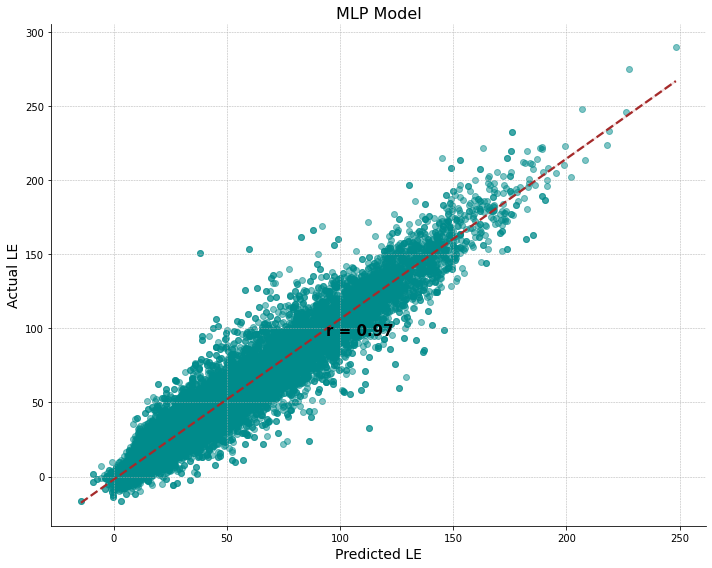

In [25]:
plt.figure(figsize=(10, 8))



ax = sns.regplot(
    x=preds['LE'],
    y=Y_test['LE'],
    scatter_kws={'alpha':0.5, 'color':'darkcyan'},
    line_kws={'color':'brown', 'ls': '--'}
)

corr = np.corrcoef(preds['LE'], Y_test['LE'])[0, 1]
plt.text(0.42, 0.38, f'r = {corr:.2f}', transform=ax.transAxes, fontsize=15, fontweight='bold')

plt.title('MLP Model', fontsize=16)
plt.xlabel('Predicted LE', fontsize=14)
plt.ylabel('Actual LE', fontsize=14)

ax.grid(True, lw=0.5, ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()